# <center>Base model(kospi)</center>



<div style="text-align: right">60150603 경제학과 박찬혁 </div>


-----------------
## google drive연동

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd /content/gdrive/My Drive/Colab Notebooks/mju_dnn/mju_DL_project

/content/gdrive/My Drive/Colab Notebooks/mju_dnn/mju_DL_project


In [0]:
import pandas as pd
import numpy as np 

In [0]:
kospi = pd.read_csv('KOSPI.csv')

In [0]:
print(kospi.head())

         Date      Open      High  ...       snp        ex   Close
0  2019-01-02  0.599885  0.566118  ...  0.237328  0.064725  258.23
1  2019-01-03  0.550398  0.515860  ...  0.183234  0.100024  255.77
2  2019-01-04  0.525750  0.510111  ...  0.256400  0.044720  257.89
3  2019-01-07  0.578402  0.559774  ...  0.271852  0.049676  261.57
4  2019-01-08  0.580129  0.552835  ...  0.293371  0.081304  259.65

[5 rows x 14 columns]


# Wavelet transform 

8


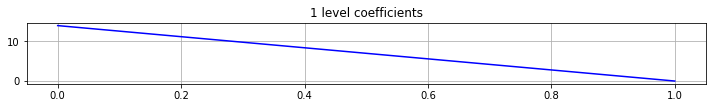

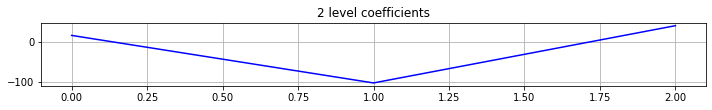

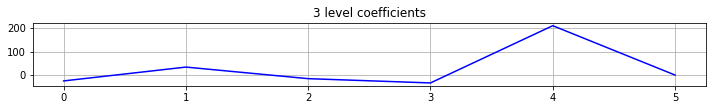

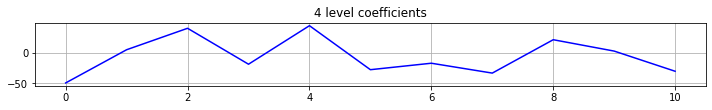

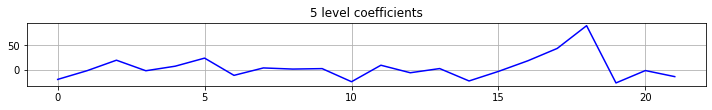

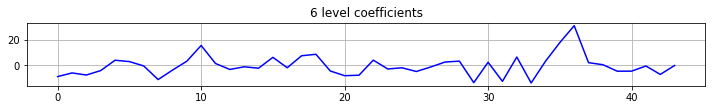

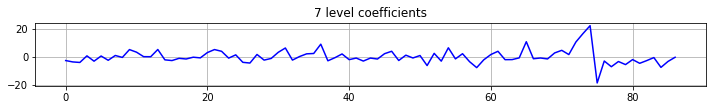

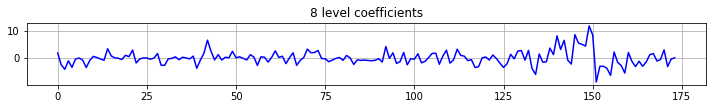

In [0]:
import matplotlib.pyplot as plt
import pywt
import math
import warnings 
warnings.filterwarnings('ignore')


levels =  int(math.log(len(kospi["Close"].values), 2)) #  시계열 길이에 따른 레벨 
print(levels)
coef = pywt.wavedec(data = kospi["Close"].values, wavelet= 'haar', level = levels) #wavelet decompostion using "haar" wavelet

for level in range(1, len(coef)) :
    fig = plt.figure(figsize = (10,10))
    plt.subplot(levels, 1, level) 
    plt.plot(coef[level], c = 'blue')
    plt.title("{} level coefficients".format(level))
    plt.grid()
    plt.tight_layout()
    plt.show()

# Thresholding(universal threshold) 

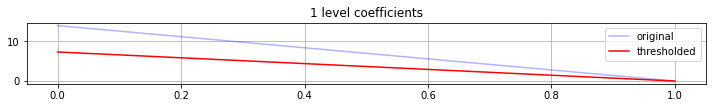

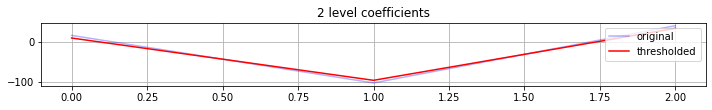

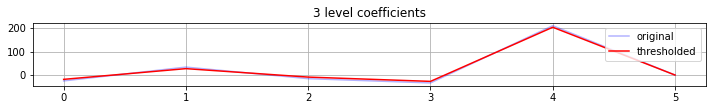

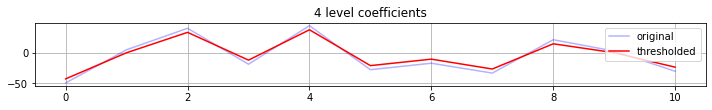

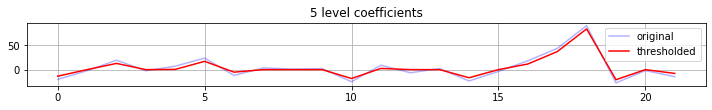

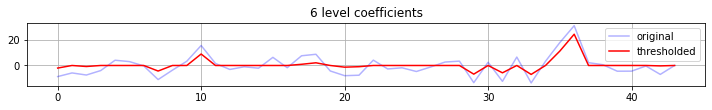

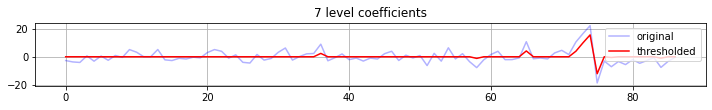

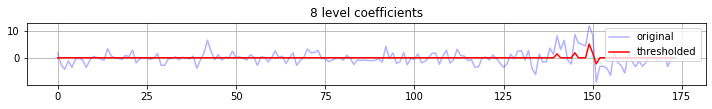

In [0]:
from statsmodels.robust import mad
sigma = 1.4826 * mad(abs(coef[-1]))

threshold = sigma * np.sqrt(2 * np.log(len(kospi["Close"].values))) # universal threshold

for level in range(1, len(coef)) :
    thresholding = pywt.threshold(data = coef[level], value = threshold, mode = 'soft')
    fig = plt.figure(figsize = (10,10))
    plt.subplot(levels, 1, level) 
    plt.plot(coef[level], c = 'blue', alpha = 0.3, label = 'original')
    plt.plot(thresholding, c = 'red', alpha = 1, label = 'thresholded')
    plt.title("{} level coefficients".format(level))
    plt.legend(loc = 'upper right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    coef[level] = thresholding

# reconstruction 

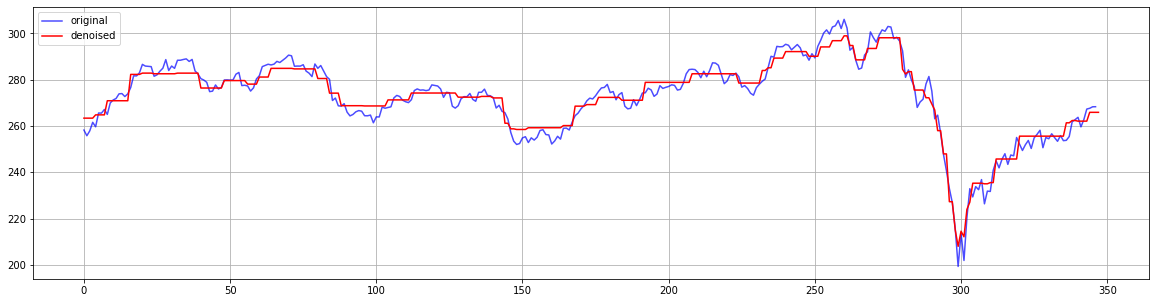

In [0]:
recon = pywt.waverec(coef, wavelet = 'haar')

fig = plt.figure(figsize = (20, 5))
plt.plot(kospi['Close'].values, alpha = 0.7, c = 'blue', label = 'original')
plt.plot(recon, c = 'red', label = 'denoised')
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [0]:
close = kospi['Close']
kospi['Close'] = recon[0:347]

# 순환신경망을 위한 시계열 데이터 전처리 

In [0]:
# feature, target split 
date = kospi['Date']
kospi.drop('Date',axis = 1, inplace=True) # 날짜 제거 
features = kospi.drop('Close', axis = 1).values
target  = kospi['Close'].values

print(features.shape)
print(target.shape)

(347, 12)
(347,)


In [0]:
n_features = features.shape[1] # 변수 개수 
timestep = 5                   # 한 배치당 5일의 데이터 학습

def temp(x,look_back) :
	output_x = []
	for i in range(len(x) - look_back- 1) :
		t = []
		for j in range(1, look_back+1) :
			t.append(x[[(i+j+1)],:])
		output_x.append(t) 
		
	return output_x

x = temp(features, look_back = timestep)

x = np.array(x)
x = x.reshape(x.shape[0], timestep, n_features)

x.shape # (n_data, 5days, n_features)

(341, 5, 12)

In [0]:
y = target[5+1 : target.shape[0]]
print(y.shape)

(341,)


# 분기별 데이터 셋 분리 

- 2020년 3월 30일 부터 5월 31일 까지의 데이터는 최종 검증 데이터로 사용한다. 총 41일 
- 2019년 1월 2일 부터 2020년 3월 27일 까지의 데이터는 5등분 하여 각각 학습 데이터와 학습 검증데이터로 사용한다. (각 60일, 총 5개로 분배)



In [0]:
# test set
x_test = x[341-41: 341]
y_test = y[341-41: 341]

print(x_test.shape)
print(y_test.shape)

(41, 5, 12)
(41,)


In [0]:
# train set
x_train = x[0:341-41]
y_train = y[0:341-41]

print(x_train.shape)
print(y_train.shape)

(300, 5, 12)
(300,)


# Stacked LSTM

In [0]:
import keras
model = keras.Sequential()
model.add(keras.layers.LSTM(100, activation='relu', input_shape = (timestep, n_features),return_sequences=True))
model.add(keras.layers.LSTM(100, activation='relu', input_shape = (timestep, n_features),return_sequences=True))
model.add(keras.layers.LSTM(100, activation='relu', input_shape = (timestep, n_features),return_sequences=True))
model.add(keras.layers.LSTM(100, activation='relu', input_shape = (timestep, n_features),return_sequences=True))
model.add(keras.layers.LSTM(100, activation='relu', input_shape = (timestep, n_features),return_sequences=False))
model.add(keras.layers.Dense(1))
model.compile(optimizer = keras.optimizers.adam(lr = 0.01), loss = 'mape')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 5, 100)            45200     
_________________________________________________________________
lstm_12 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 366,901
Trainable params: 366,901
Non-trainable params: 0
________________________________________________

- 총 366,901개의 파라미터를 학습 한다. 

# 학습 


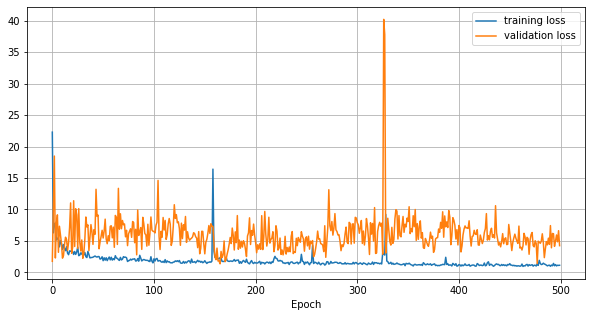

In [0]:
history = model.fit(x_train,y_train, epochs= 500, batch_size=1, verbose =0, validation_data=(x_test,y_test))

fig = plt.figure(figsize = (10,5))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label= 'validation loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

In [0]:
 print("Base model의 성능-> MAPE : {} %".format(np.round(np.min(history.history['val_loss']),3)))

Base model의 성능-> MAPE : 1.37 %


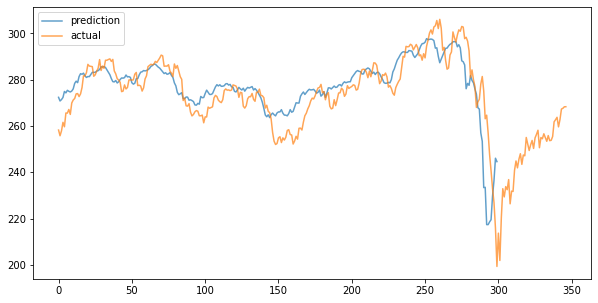

In [0]:

pred = model.predict(x_train)
actual = pd.read_csv('KOSPI.csv')
actual = actual['Close']

plt.figure(figsize = (10,5))
plt.plot(pred, label = 'prediction', alpha = 0.7)
plt.plot(actual, label = 'actual', alpha = 0.7)
plt.legend(loc = 'upper left')

# 모델 저장 

In [0]:
from keras.models import load_model
model.save('base_model.h5')

# 모델 불러오기  

In [0]:
base_model = load_model('base_model.h5')
model_on_base = keras.models.Sequential(base_model.layers[:-2]) #출력층 제외 
model_on_base.add(keras.layers.LSTM(100, activation='relu', input_shape = (timestep, n_features),return_sequences=False))
model_on_base.add(keras.layers.Dense(1))

In [0]:
for layer in model_on_base.layers[:-2] :
    layer.trainable = False  
model_on_base.compile(optimizer = keras.optimizers.adam(lr = 0.01), loss = 'mape')

print(model_on_base.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 5, 100)            45200     
_________________________________________________________________
lstm_12 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 366,901
Trainable params: 80,501
Non-trainable params: 286,400
___________________________________________

# 삼성전자 주식 학습 

In [0]:
samsung = pd.read_csv("SAMSUNG.csv")
samsung.drop('Date', axis =1 , inplace = True)
features = samsung.drop('Close', axis = 1).values
target  = samsung['Close'].values
print(features.shape)
print(target.shape)

(347, 12)
(347,)


In [0]:
n_features = features.shape[1] # 변수 개수 
timestep = 5                   # 한 배치당 5일의 데이터 학습

def temp(x,look_back) :
	output_x = []
	for i in range(len(x) - look_back- 1) :
		t = []
		for j in range(1, look_back+1) :
			t.append(x[[(i+j+1)],:])
		output_x.append(t) 
		
	return output_x

x = temp(features, look_back = timestep)

x = np.array(x)
x = x.reshape(x.shape[0], timestep, n_features)

y = target[5+1 : target.shape[0]]

print(x.shape)   # (n_data, 5days, n_features)
print(y.shape)

(341, 5, 12)
(341,)


In [0]:
model_on_base.fit(x,y , batch_size=1, verbose = 1, epochs = 4)

Epoch 1/4
341/341 [==============================] - 7s 21ms/step - loss: 16.4378
Epoch 2/4
341/341 [==============================] - 6s 19ms/step - loss: 10.4704
Epoch 3/4
341/341 [==============================] - 6s 19ms/step - loss: 8.9962
Epoch 4/4
341/341 [==============================] - 6s 19ms/step - loss: 7.7155
